In [1]:
import numpy as np
from scipy.linalg import sqrtm
import scipy as sc
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from mpi4py import MPI
from tqdm import tqdm
n_qubits=6
c=0

# Definition of the quantum gates

In [2]:
X=np.array([[0,1],[1,0]],dtype="complex")
Y=np.array([[0,-1j],[1j,0]],dtype="complex")
Z=np.array([[1,0],[0,-1]],dtype="complex")
sigma=np.array([np.eye(2,dtype="complex"),X,Y,Z])
I=np.eye(2,dtype="complex")
H=np.array([[1,1],[1,-1]],dtype="complex")/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype="complex")

# Numpy transformations

In [3]:
def get_psi(n_qubits): #Random state Haar measure
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    psi=psi/np.exp(1j*np.angle(psi[0][0]))
    return psi
def equal(a,b):
    return np.linalg.norm(a-b)<0.000001 #проверка равентства матриц
def is_unitary(matrix):
    if(np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))<0.00001):
        return True
    return np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
def is_hermit(matrix): #return True if matrix is hermitian
    return np.linalg.norm(matrix.T.conjugate()-matrix)<0.0000001
def trace(a):
    return np.trace(a)/len(a)
def convert_base(value, base, length=16,n_qubits=n_qubits):# меняет систему исчесления
    if value < 0:
        value = ( 1<<length ) + value
 
    res = ''
    while value > 0:
        res = str(value % base) + res
        value //= base
    while len(res)<n_qubits:
        res="0"+res
    return res
def decompose(A,n_qubits=n_qubits): # разложение на строчки Паули
    parameters=np.array([])
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        parameters=np.append(parameters,trace(A@a))
    return parameters
def compose(parameters,n_qubits=n_qubits): # сборка по параметрам разложения
    A=np.zeros((2**n_qubits,2**n_qubits),dtype="complex")
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        A=A+parameters[i]*a
    return A
def Pauli_system(a): #Auxiliary function for Pauli strings decomposition
    Pauli_string=''
    for i in range(len(a)):
        if a[i]=='0':
            Pauli_string+="I"
        if a[i]=="1":
            Pauli_string+="X"
        if a[i]=="2":
            Pauli_string+="Y"
        if a[i]=="3":
            Pauli_string+="Z"
    return Pauli_string 
def write_decomposition(parameters,n_qubits=n_qubits): #write decomposition to Pauli strings and return non-zero strings
    a=""
    b=""
    for i in range(len(parameters)):
        if np.abs(parameters[i])>0.00001:
            if np.imag(parameters[i])==0:
                if np.real(parameters[i])>0:
                    print("+ "+str(np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            elif np.real(parameters[i])==0:
                if np.imag(parameters[i])>0:
                    print("+ "+str(np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ") 
            else:
                if np.imag(parameters[i])>0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"+ "+str(np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])<0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"- "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])>0 and np.real(parameters[i])<0:
                    print("+ (-"+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- ("+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            b+=Pauli_system(convert_base(i,4,n_qubits=n_qubits))+";"
    return b.split(";")[:-1:]
def Unitaries(decomposition,n_qubits=n_qubits): #return matrices in decomposition (first use decompose function)
    Unit=np.eye(2**n_qubits,dtype="complex")
    for i in range(1,len(decomposition)):
        if decomposition[i]!=0:
            a=sigma[int(convert_base(i,4)[0])]
            for j in range(1,n_qubits):
                a=np.kron(a,sigma[int(convert_base(i,4)[j])])
            Unit=np.append(Unit,a,axis=0)
    return np.reshape(Unit,(len(decomposition[decomposition!=0]),2**n_qubits,2**n_qubits))
def h_decompose(matrix): #decompose a matrix to sum of the 2 hermitian operators
    H1=0.5*(matrix+matrix.T.conjugate())
    H2=-0.5j*(matrix-matrix.T.conjugate())
    if is_hermit(H1) and is_hermit(H2):
        return H1,H2
    else:
        return False
def u_decompose(A): #decompose a hermitian matrix to sum of 2 unitaries
    U1=A+1j*sqrtm(np.eye(len(A))-A@A)
    U2=A-1j*sqrtm(np.eye(len(A))-A@A) 
    if is_unitary(U1) and is_unitary(U2):
        return U1,U2
    else:
        return False
def Rx(theta):
    return np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],[-1j*np.sin(theta/2),np.cos(theta/2)]])
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def L(n=n_qubits):
    matrix=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        matrix[i][i-1]=1
    return matrix
def U3gate(x,y,z):
    return np.array([[np.cos(x/2),(-1)*np.exp(1j*z)*np.sin(x/2)],[np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def CU3gate(x,y,z):
    return np.array([[1,0,0,0],[0,1,0,0],[0,0,np.cos(x/2),-np.exp(1j*z)*np.sin(x/2)],[0,0,np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def two_qubit_state(state):
    if np.imag(state[0][0])>0.00000001:
        print("invalid state")
        return 0
    x1=2*np.arccos(np.sqrt(np.abs(state[0][0])**2+np.abs(state[1][0])**2))
    x2=np.angle(state[2][0])
    y1=2*np.arctan(np.abs((state[1][0]))/(np.abs(state[0][0])))
    y2=np.angle(state[1][0])
    z1=2*np.arccos(np.abs(state[2][0])/np.sqrt(1-np.abs(state[0][0])**2-np.abs(state[1][0])**2))-y1
    z2=np.angle(state[3][0])-np.angle(state[2][0])
    return CU3gate(z1,z2,-y2)@np.kron(U3gate(x1,x2,0),U3gate(y1,y2,0))
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def rho_fidelity(a,b):
    fidelity=(np.trace(sqrtm(sqrtm(a)@b@sqrtm(a))))**2
    if np.abs(np.imag(fidelity))>0.0000001:
        print("error")
        return 0
    return np.real(fidelity)
def create_A(c,n_qubits=n_qubits):
    A=np.zeros((2**n_qubits,2**n_qubits),dtype=complex)
    for i in range(2**n_qubits):
        if i!=(2**n_qubits-1):
            A[i][i+1]=1
        if i!=0:
            A[i][i-1]=1
        A[i][i]=-2-c
    A[0][-1]=1
    A[-1][0]=1
    return A    

# A matrix

In [4]:
#creation A
A=create_A(c)

#Substituion of the spectrum
A_new_F_shift=np.diag(np.array([-c-4*(np.pi*i/2**n_qubits-np.pi/2)**2 for i in range(2**n_qubits)])) 
A_new_F=A_new_F_shift
for i in range(2**(n_qubits-1)):
    A_new_F=L()@A_new_F@(L().T.conjugate())
    
#decomposition to Pauli strings (will be printed below)
set_u=write_decomposition(decompose(A_new_F)) 

#pseudo inversed matrix
val,vec=np.linalg.eigh(A)
val=np.array([1/val[i] for i in range(len(val)-1)])
val=np.append(val,0.)
A_1=vec@np.diag(val)@vec.T


#Fourier basis
A_new=QFT().T.conjugate()@A_new_F@QFT()
A_F=QFT()@A@(QFT().T.conjugate())

#pseudo inversed matrix
val=np.linalg.eigh(A_new)[0]
val=np.array([1/val[i] for i in range(len(val)-1)])
val=np.append(val,0.)
A_new_1=vec@np.diag(val)@vec.T


- 3.291474514621109 IIIIII - 0.004819142773969443 IIIIIZ - 0.009638285547938441 IIIIZI - 0.00963828554793933 IIIIZZ - 0.01927657109587753 IIIZII - 0.019276571095877867 IIIZIZ - 0.038553142191755305 IIIZZI - 0.038553142191755374 IIZIII - 0.038553142191755416 IIZIIZ - 0.07710628438351064 IIZIZI - 0.1542125687670211 IIZZII - 0.07710628438351057 IZIIII - 0.07710628438351061 IZIIIZ - 0.15421256876702122 IZIIZI - 0.30842513753404244 IZIZII - 0.6168502750680849 IZZIII + 0.15421256876702127 ZIIIII + 0.15421256876702139 ZIIIIZ + 0.3084251375340425 ZIIIZI + 0.6168502750680849 ZIIZII + 1.2337005501361697 ZIZIII + 2.4674011002723395 ZZIIII 

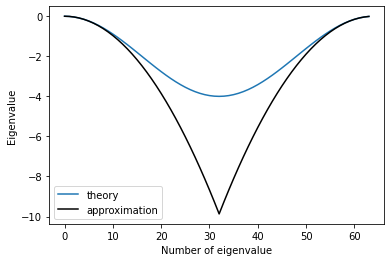

In [5]:
plt.plot(np.diag(np.real(A_F)))
plt.plot(np.real(np.diag(A_new_F)),color="black")
plt.legend(["theory","approximation"])
plt.xlabel("Number of eigenvalue")
plt.ylabel("Eigenvalue")
plt.show()

# vector b (initial state)

In [6]:
b_init=np.array([],dtype=complex)
for i in np.diag(A_new_F):#excluding of the high harmonics 
    if i!=0 and i>-100:
        b_init=np.append(b_init,np.random.normal()+1j*np.random.normal())
    else:
        b_init=np.append(b_init,0)
b_init=np.reshape(b_init,(2**n_qubits,1))
b_init=b_init/(np.sqrt(b_init.conjugate().T@b_init))
b=QFT().T.conjugate()@b_init

# Solution for A and A_new(substituded spectrum)

In [7]:
x_true=A_1@b
x_new=A_new_1@b
x_new=x_new/np.sqrt(np.abs(x_new.T.conjugate()@x_new))
x_true=x_true/np.sqrt(np.abs(x_true.T.conjugate()@x_true))
print("100% error level = "+str((np.abs(b.T.conjugate()@x_new)**2)[0][0]))
print("Fidelity of solutions = "+str((np.abs(x_true.T.conjugate()@x_new)**2)[0][0]))

100% error level = 0.062382317424458225
Fidelity of solutions = 0.999957325951181


In [8]:
qft=QFT()
qft_cc=QFT().T.conjugate()
def gate_string(string,n_qubits=n_qubits):#string --str
    if string[0]=="I":
        gate=I
    else:
        gate=Z
    for i in range(1,n_qubits):
        if string[i]=="I":
            gate=np.kron(gate,I)
        else:
            gate=np.kron(gate,Z)
    return qft_cc@gate@qft

def gate_string_F(string,n_qubits=n_qubits):#string --str
    if string[0]=="I":
        gate=I
    else:
        gate=Z
    for i in range(1,n_qubits):
        if string[i]=="I":
            gate=np.kron(gate,I)
        else:
            gate=np.kron(gate,Z)
    return gate

def x_s(parameters,n_qubits=n_qubits,b=b):#parameters --dictionary
    result=np.zeros((2**n_qubits,2**n_qubits),dtype=complex)
    for i in parameters:
        result+=parameters[i]*gate_string_F(i,n_qubits=n_qubits)
    return qft_cc@result@qft@b

def string_multiplication(a,b,n_qubits=n_qubits):# a,b -- str only for I and Z
    result=""
    for i in range(n_qubits):
        if a[i]==b[i]:
            result+="I"
        else:
            result+="Z"
    return result   

def tree_selection(branch,branch_optimal,b=b,set_u=set_u,n_qubits=n_qubits):#branch,branch_optimal--dictionary
    gradient_largest=0
    for i in set_u:
        applicant=string_multiplication(branch[-1],i,n_qubits=n_qubits)
        gradient=2*(gate_string(applicant,n_qubits=n_qubits)@b).T.conjugate()@A_new@A_new@x_s(branch_optimal,n_qubits=n_qubits,b=b)-2*(gate_string(applicant,n_qubits=n_qubits)@b).T.conjugate()@A@b
        if (np.abs(gradient)>np.abs(gradient_largest) and (applicant not in branch)):
            result=applicant
             gradient_largest=gradient
    return result

def Loss_function(x,branch,n_qubits=n_qubits,b=b):
    parameters={branch[i]:x[i] for i in range(len(branch))}
    state=x_s(parameters,n_qubits=n_qubits,b=b)
    return np.real((state.T.conjugate()@A_new@A_new@state)-2*np.real(b.T.conjugate()@A_new@state)+1)[0][0]
    

def optimizator(branch,b=b,n_qubits=n_qubits):
    x=sc.optimize.minimize((lambda y: Loss_function(y,branch=branch,n_qubits=n_qubits,b=b)),np.array([0 for i in range(len(branch))]))
    branch_optimal={branch[i]:x.x[i] for i in range(len(branch))}
    solution=x_s(branch_optimal,n_qubits=n_qubits,b=b)
    solution/=np.sqrt(solution.T.conjugate()@solution)
    Fidelity=(np.abs(x_new.T.conjugate()@solution)**2)[0][0]
#    print("Fidelity = "+str(Fidelity)+"\n"+"Loss function value = "+str(x.fun)+"\n"+"parameters = "+str(x.x))# Fidelity test
    return branch_optimal, Fidelity, x.fun
        
            
            
            
            
        
        
        
        
        
        

# Algorithm

In [9]:
%%time
depth=(2**n_qubits)-1
branch=np.array(["I"*n_qubits])
Fidelity_samples=np.array([])
losses_samples=np.array([])
with open('Fidelities8.txt', 'w', encoding='utf-8') as fid:
    with open('Loss_function8.txt', 'w', encoding='utf-8') as los:
        for i in range(depth):
            branch_optimal, Fidelity, losses=optimizator(branch,b=b,n_qubits=n_qubits)
            branch=np.append(branch,tree_selection(branch,branch_optimal,b=b,set_u=set_u,n_qubits=n_qubits))
            Fidelity_samples=np.append(Fidelity_samples,Fidelity)
            losses_samples=np.append(losses_samples,losses)
            print(i,Fidelity,losses)
            fid.write(str(Fidelity)+"\t")
            los.write(str(losses)+"\t")
        fid.write("\n")
        los.write("\n")
            
#    print()
#print(depth,branch)
branch_optimal, Fidelity, losses=optimizator(branch,b=b,n_qubits=n_qubits)  
Fidelity_samples=np.append(Fidelity_samples,Fidelity)
losses_samples=np.append(losses_samples,losses)
print(depth,Fidelity,losses)
        
    
    

0 0.062382317424458794 0.49824515309521433
1 0.10189437422105703 0.28100312242615044
2 0.08936024627149282 0.2571288829809687
3 0.1644215656137026 0.13893353920124862
4 0.1618303909387041 0.13488918132845362
5 0.1244223628045399 0.11678152018246457
6 0.11700538259224279 0.111890352084422
7 0.40610331504695646 0.08355669672916033
8 0.4054076602687782 0.0830739613979048
9 0.3940629548638419 0.07844681977916601
10 0.39455896017062075 0.07841049763018937
11 0.24417747668073825 0.047318578955675816
12 0.24258286566765958 0.04630675333681267
13 0.2240763490220885 0.04299534478623479
14 0.21750592816881373 0.04076162715050913
15 0.8639118530306975 0.027933310339606665
16 0.8638935719287287 0.027926368399558532
17 0.8638669959602554 0.027920856195964072
18 0.8637863991161816 0.027780662046074434
19 0.8632364720837679 0.027708442763518804
20 0.8631580733795207 0.027611523731211784
21 0.8627606460601209 0.02754818378673829
22 0.8627570093207373 0.027548007783614437
23 0.8597161067263012 0.027539

KeyboardInterrupt: 

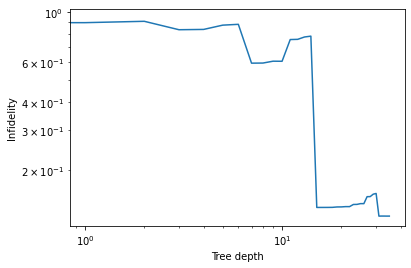

In [10]:
plt.plot(1-Fidelity_samples)
plt.xlabel("Tree depth")
plt.ylabel("Infidelity")
plt.yscale('log')
plt.xscale('log')
plt.show()

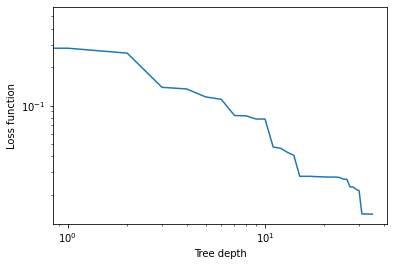

In [11]:
plt.plot(losses_samples)
plt.xlabel("Tree depth")
plt.ylabel("Loss function")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [12]:
with open('Fidelities8.txt', 'w', encoding='utf-8') as fid:
    with open('Loss_function8.txt', 'w', encoding='utf-8') as los:
        for Fidelity in Fidelity_samples:
            fid.write(str(Fidelity)+"\t")
        for losses in losses_samples:
            los.write(str(losses)+"\t")


# DEBUG